# Feature Selection

**Задание**

Вы получили основные навыки обработки данных, теперь пора испытать их на практике. Сейчас вам предстоит заняться задачей классификации.

Представлен датасет центра приюта животных, и вашей задачей будет обучить модель таким образом, чтобы  по определенным признакам была возможность максимально уверенно предсказать метки 'Adoption' и 'Transfer' (столбец “outcome_type”).

Здесь вы вольны делать что угодно. Я хочу видеть от вас:
1. Проверка наличия/обработка пропусков
2. Проверьте взаимосвязи между признаками
3. Попробуйте создать свои признаки
4. Удалите лишние
5. Обратите внимание на текстовые столбцы. Подумайте, что можно извлечь полезного оттуда
6. Использование профайлера вам поможет.
7. Не забывайте, что у вас есть PCA (Метод главных компонент). Он может пригодиться.

Вспомните о всем, что я говорил на предыдущих занятиях. Не все будет пригодится, но в жизни вам никто не будет говорить, что использовать :)

Хорошим классификатором для этой задачи будет "Случайный лес" (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Понимать суть работы "леса" не обязательно на данном этапе, но качество предсказаний будет выше, чем с линейным классификатором. (если желаете, вот гайд https://adataanalyst.com/scikit-learn/linear-classification-method/)

Желаю успеха :)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv("./data/aac_shelter_outcomes.csv", sep=",", encoding="utf-8")
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


Посмотрим заодно и на размер датасета:

In [3]:
df.shape

(78256, 12)

## Первичная работа

### Проверка на пропуски

In [4]:
for col in df.columns:
    print(f"COL: {col}, NAN: {df[col].isnull().sum()}") 

COL: age_upon_outcome, NAN: 8
COL: animal_id, NAN: 0
COL: animal_type, NAN: 0
COL: breed, NAN: 0
COL: color, NAN: 0
COL: date_of_birth, NAN: 0
COL: datetime, NAN: 0
COL: monthyear, NAN: 0
COL: name, NAN: 23886
COL: outcome_subtype, NAN: 42293
COL: outcome_type, NAN: 12
COL: sex_upon_outcome, NAN: 2


Очень много пропусков в колонках `outcome_subtype` (примерно половина), `name`. Единичные пропуски в `age_upon_outcome`, `outcome_type` и `sex_upon_outcome`.

**Вывод:** 

* `outcome_subtype` удаляем,

* `name` переводим в категорию: было имя или нет,

* `age_upon_outcome`, `outcome_type` и `sex_upon_outcome` пока не трогаем.

### Проверка дублей

#### Одинаковые столбцы?

Столбцы `monthyear` и `datetime` выглядят подозрительно похоже. Проверим, совпадают ли они?

In [5]:
(df["monthyear"] == df["datetime"]).all()

True

Совпадают.

**Вывод:** удаляем `datetime` (мне меньше нравится название).

#### Одинаковые `animal_id`?

In [6]:
df[df["animal_id"].duplicated(keep=False)]["animal_id"]

19       A684460
22       A666660
37       A665344
47       A660098
52       A688352
          ...   
78225    A756164
78227    A756164
78246    A738395
78247    A761266
78249    A761265
Name: animal_id, Length: 13266, dtype: object

Ого, 13266 животных, которые попадали в шелтер больше одного раза! Это придётся учесть.

**Вывод:** добавлю категорию `repeat`, чтобы учитывать это повторное попадание.

### Убираем лишнее

* `outcome_subtype` — слишком много пропусков

* `datetime` — не несущий смысла столбец

* `outcome_type`, который не `Transfer` и не `Adoption` — не целевые переменные для предсказания

In [7]:
df.drop(["outcome_subtype", "datetime"], axis=1, inplace=True)
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,monthyear,name,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,NaN,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Lucy,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,*Johnny,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,Monday,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,NaN,Euthanasia,Unknown


In [8]:
categories_to_keep = ["Transfer", "Adoption"]
df = df[df["outcome_type"].isin(categories_to_keep)].reset_index(drop=True)
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,monthyear,name,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,NaN,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Lucy,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,*Johnny,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,Monday,Transfer,Neutered Male
4,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,*Edgar,Transfer,Intact Male


Посмотрим, насколько датасет стал меньше:

In [9]:
df.shape

(56611, 10)

-22 тысячи примеров, неплохо.

А сколько дублей животных осталось?

In [10]:
df[df["animal_id"].duplicated(keep=False)]["animal_id"]

14       A684460
32       A665344
44       A688352
66       A674053
67       A688036
          ...   
56562    A758320
56563    A762931
56565    A760749
56587    A756164
56588    A756164
Name: animal_id, Length: 7171, dtype: object

Стало почти в два раза меньше (7100 против ~13000), но всё равно много.

## Предобработка

### Имя

Как и хотела, сделаю отдельную категорию для питомцев с именем. После этого изначальный столбец удалю.

In [11]:
def extract_name(df_data):
    has_name = 0
    if df_data != "NaN":
        has_name = 1
    return has_name

In [12]:
df["has_name"] = df["name"].fillna(value="NaN").apply(extract_name)
df.drop(["name"], axis=1, inplace=True)
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,monthyear,outcome_type,sex_upon_outcome,has_name
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,Transfer,Intact Male,0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Transfer,Spayed Female,1
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,Adoption,Neutered Male,1
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,Transfer,Neutered Male,1
4,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,Transfer,Intact Male,1


### Выделение признаков пола и фертильности

У нас сейчас есть столбец `sex_upon_outcome`. Возможно, его стоит поделить на два разных признака — пол `sex` и фертильность животного `fertility`. Исходный столбец после этого удалим, чтобы не мешался.

In [13]:
def extract_sex(df_data):
    sex = ""
    if "Male" in df_data:
        sex = "male"
    elif "Female" in df_data:
        sex = "female"
    else:
        sex = "Unknown"
    return sex

In [14]:
def extract_fertility(df_data):
    fertility = ""
    if ("Spayed" in df_data) or ("Neutered" in df_data):
        fertility = "sterilized"
    elif "Intact" in df_data:
        fertility = "intact"
    else:
        fertility = "Unknown"
    return fertility

In [15]:
df["sex"] = df["sex_upon_outcome"].apply(extract_sex)
df["fertility"] = df["sex_upon_outcome"].apply(extract_fertility)
df.drop(columns=["sex_upon_outcome"], inplace=True)
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,monthyear,outcome_type,has_name,sex,fertility
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,Transfer,0,male,intact
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Transfer,1,female,sterilized
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,Adoption,1,male,sterilized
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,Transfer,1,male,sterilized
4,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,Transfer,1,male,intact


### Возраст на момент выпуска из шелтера

Возраст в шелтере можно спокойно посчитать по такой формуле:

* `age_days` = `monthyear` - `date_of_birth`, 
* округлить получившееся значение до дней, 
* перевести его в целочисленный тип.

In [16]:
age_series = pd.to_datetime(df["monthyear"]) - pd.to_datetime(df["date_of_birth"])
df["age_days"] = age_series.astype("timedelta64[D]").astype(int)
df.drop(["age_upon_outcome", "date_of_birth", "monthyear"], axis=1, inplace=True)
df.head()

,animal_id,animal_type,breed,color,outcome_type,has_name,sex,fertility,age_days
0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,Transfer,0,male,intact,15
1,A666430,Dog,Beagle Mix,White/Brown,Transfer,1,female,sterilized,366
2,A675708,Dog,Pit Bull,Blue/White,Adoption,1,male,sterilized,429
3,A680386,Dog,Miniature Schnauzer Mix,White,Transfer,1,male,sterilized,3300
4,A664462,Dog,Leonberger Mix,Brown/White,Transfer,1,male,intact,126


### Повторные попадания

Если животное попадает в шелтер повторно, присвоим ему также категорию `returning_animal`, но перед этим посмотрим: есть ли выбросы? Может, какие-то животные возвращаются особенно часто?

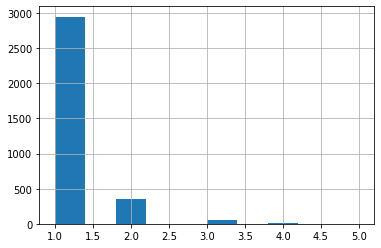

In [17]:
dups = df[df.duplicated(subset=["animal_id"])]
dups.pivot_table(index=["animal_id"], aggfunc="size").hist()

Вроде как нет, все в основном возвращаются один раз, так что мудрить с категориями не будем.

In [18]:
df["returning"] = df.duplicated(subset=["animal_id"]).astype(int)
df.drop(["animal_id"], axis=1, inplace=True)
df.head()

,animal_type,breed,color,outcome_type,has_name,sex,fertility,age_days,returning
0,Cat,Domestic Shorthair Mix,Orange Tabby,Transfer,0,male,intact,15,0
1,Dog,Beagle Mix,White/Brown,Transfer,1,female,sterilized,366,0
2,Dog,Pit Bull,Blue/White,Adoption,1,male,sterilized,429,0
3,Dog,Miniature Schnauzer Mix,White,Transfer,1,male,sterilized,3300,0
4,Dog,Leonberger Mix,Brown/White,Transfer,1,male,intact,126,0


### Окрас

Посмотрим, сколько разных окрасов бывает:

In [19]:
df["color"].value_counts()

Black/White              6111
Black                    5141
Brown Tabby              3975
Brown Tabby/White        2083
Orange Tabby             1914
                         ... 
Brown Tabby/Gray            1
Seal Point/Buff             1
Lynx Point/Gray Tabby       1
Cream/Silver                1
White/Silver Tabby          1
Name: color, Length: 475, dtype: int64

Ой, много! А если оставить только первый цвет?

In [20]:
def extract_first_color(df_data):
    color = df_data
    if "/" in df_data:
        color = df_data.split("/")[0]
    return color

df["main_color"] = df["color"].apply(extract_first_color)

In [21]:
df["main_color"].value_counts()

Black                13887
White                 6918
Brown Tabby           6126
Brown                 3818
Tan                   3616
Orange Tabby          2894
Blue                  2661
Blue Tabby            1524
Tricolor              1477
Brown Brindle         1423
Red                   1342
Tortie                1319
Calico                1309
Torbie                 942
Chocolate              802
Cream Tabby            674
Sable                  592
Cream                  477
Gray                   477
Lynx Point             424
Yellow                 388
Buff                   378
Fawn                   359
Seal Point             314
Blue Merle             246
Black Tabby            218
Flame Point            181
Black Brindle          180
Gray Tabby             178
Black Smoke            136
Brown Merle            134
Orange                 110
Gold                   104
Blue Tick               95
Silver Tabby            86
Red Tick                84
Lilac Point             74
R

Уже лучше. Оставим этот столбец в таком виде.

In [22]:
df.drop(["color"], axis=1, inplace=True)
df.head()

,animal_type,breed,outcome_type,has_name,sex,fertility,age_days,returning,main_color
0,Cat,Domestic Shorthair Mix,Transfer,0,male,intact,15,0,Orange Tabby
1,Dog,Beagle Mix,Transfer,1,female,sterilized,366,0,White
2,Dog,Pit Bull,Adoption,1,male,sterilized,429,0,Blue
3,Dog,Miniature Schnauzer Mix,Transfer,1,male,sterilized,3300,0,White
4,Dog,Leonberger Mix,Transfer,1,male,intact,126,0,Brown


### Порода

Посмотрим, что есть:

In [23]:
df["breed"].value_counts()

Domestic Shorthair Mix                20809
Pit Bull Mix                           3509
Chihuahua Shorthair Mix                3399
Labrador Retriever Mix                 3258
Domestic Medium Hair Mix               2049
                                      ...  
Boston Terrier/Miniature Schnauzer        1
Akita/German Shepherd                     1
Old English Sheepdog                      1
Australian Shepherd/Siberian Husky        1
Cockatoo Mix                              1
Name: breed, Length: 1803, dtype: int64

Судя по всему, породы бывают чистые и смешанные (mix). Объединим породы вместе и заведём дополнительный признак для метисов:

In [24]:
def extract_mix(df_data):
    is_mix = 0
    if df_data.endswith("Mix"):
        is_mix = 1
    return is_mix

def transform_breed(df_data):
    if df_data.endswith("Mix"):
        df_data = df_data[:-4]
    return df_data

In [25]:
df["is_mix"] = df["breed"].apply(extract_mix)
df["breed"] = df["breed"].apply(transform_breed)
df.head()

,animal_type,breed,outcome_type,has_name,sex,fertility,age_days,returning,main_color,is_mix
0,Cat,Domestic Shorthair,Transfer,0,male,intact,15,0,Orange Tabby,1
1,Dog,Beagle,Transfer,1,female,sterilized,366,0,White,1
2,Dog,Pit Bull,Adoption,1,male,sterilized,429,0,Blue,0
3,Dog,Miniature Schnauzer,Transfer,1,male,sterilized,3300,0,White,1
4,Dog,Leonberger,Transfer,1,male,intact,126,0,Brown,1


## Зависимости

Посмотрим на корреляцию признаков, если она есть:

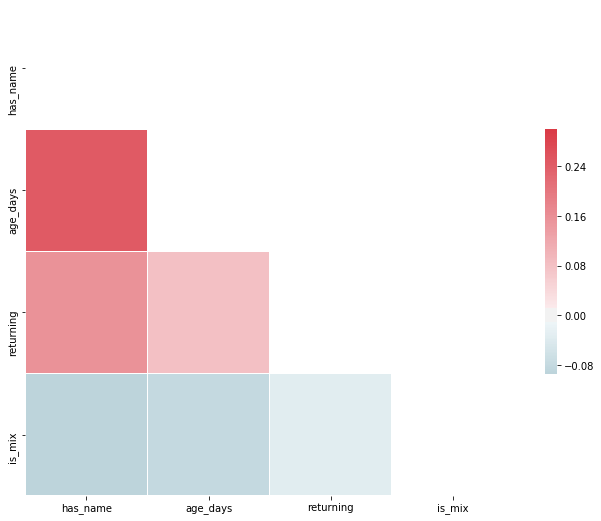

In [26]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Чем старше животное, тем более вероятно, что у него есть кличка — логично. Выбрасывать ничего не будем — это всё же разные по сути своей признаки.

## Кодирование признаков

Признаки `animal_type`, `sex`, `fertility` закодируем через LabelEncoder.

In [27]:
from sklearn.preprocessing import LabelEncoder

In [28]:
le = LabelEncoder()

df["animal_type"] = le.fit_transform(df["animal_type"])
df["sex"] = le.fit_transform(df["sex"])
df["fertility"] = le.fit_transform(df["fertility"])

df.head()

,animal_type,breed,outcome_type,has_name,sex,fertility,age_days,returning,main_color,is_mix
0,1,Domestic Shorthair,Transfer,0,2,1,15,0,Orange Tabby,1
1,2,Beagle,Transfer,1,1,2,366,0,White,1
2,2,Pit Bull,Adoption,1,2,2,429,0,Blue,0
3,2,Miniature Schnauzer,Transfer,1,2,2,3300,0,White,1
4,2,Leonberger,Transfer,1,2,1,126,0,Brown,1


Признаки породы и окраса нужно категоризировать, чтобы его переварила машина. Воспользуемся one-hot encoding.

In [29]:
df = pd.get_dummies(df, columns=["breed", "main_color"])
df.head()

,animal_type,outcome_type,has_name,sex,fertility,age_days,returning,is_mix,breed_Abyssinian,breed_Affenpinscher,...,main_color_Silver Lynx Point,main_color_Silver Tabby,main_color_Tan,main_color_Torbie,main_color_Tortie,main_color_Tortie Point,main_color_Tricolor,main_color_White,main_color_Yellow,main_color_Yellow Brindle
0,1,Transfer,0,2,1,15,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Transfer,1,1,2,366,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2,Adoption,1,2,2,429,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,Transfer,1,2,2,3300,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2,Transfer,1,2,1,126,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Обучение

Отделяем признаки для обучения от целевого:

In [30]:
X = df.drop(["outcome_type"], axis=1)
y = df["outcome_type"].values

Преобразуем целевой признак через LabelEncoder, чтобы можно было считать метрики качества:

In [31]:
y = le.fit_transform(y)

Финальная проверка: первая размерность должна совпасть.

In [32]:
print(X.shape, y.shape)

(56611, 1686) (56611,)


Делим выборки на обучающую и тестовую:

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33, 
                                                    random_state=42)

Обучаем модель:

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Проверяем:

In [37]:
from sklearn.metrics import classification_report

In [38]:
y_pred = forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82     10927
           1       0.76      0.71      0.73      7755

    accuracy                           0.79     18682
   macro avg       0.78      0.78      0.78     18682
weighted avg       0.79      0.79      0.79     18682



## Важность признаков

Построю 10 самых важных признаков и их вклад в предсказания модели.

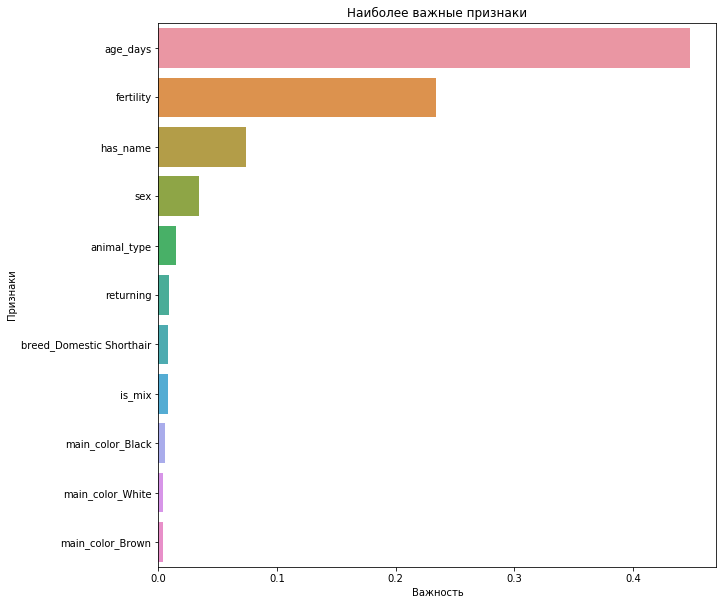

In [39]:
headers = list(X_train.columns.values)
feature_imp = pd.Series(forest.feature_importances_, index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp[:11], y=feature_imp.index[:11])

plt.xlabel("Важность")
plt.ylabel("Признаки")
plt.title("Наиболее важные признаки");

## Сжатие размерности, PCA

PCA подходит, когда у нас есть какой-то один признак с сильной вариативностью — в нашем случае это возраст.

Попробуем снижать размерности в интервале [1; 10]. 

In [40]:
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score

In [41]:
results = []
for n_dimensions in range(1, 11):
    pca = PCA(n_components=n_dimensions)
    pca.fit(X)
    # преобразуем train и test
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    # запускаем модель
    forest_pca = RandomForestClassifier(random_state=42)
    forest_pca.fit(X_train_pca, y_train)
    # проверяем
    y_pred_pca = forest_pca.predict(X_test_pca)
    results.append(f1_score(y_test, y_pred_pca))
    print(classification_report(y_test, y_pred_pca))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80     10927
           1       0.74      0.63      0.68      7755

    accuracy                           0.75     18682
   macro avg       0.75      0.74      0.74     18682
weighted avg       0.75      0.75      0.75     18682

              precision    recall  f1-score   support

           0       0.78      0.85      0.81     10927
           1       0.76      0.66      0.71      7755

    accuracy                           0.77     18682
   macro avg       0.77      0.75      0.76     18682
weighted avg       0.77      0.77      0.77     18682

              precision    recall  f1-score   support

           0       0.80      0.86      0.83     10927
           1       0.78      0.69      0.73      7755

    accuracy                           0.79     18682
   macro avg       0.79      0.78      0.78     18682
weighted avg       0.79      0.79      0.79     18682

              preci

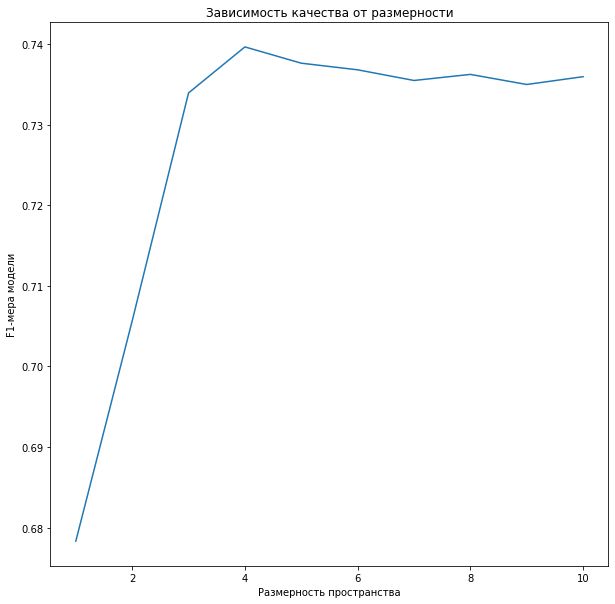

In [42]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(x=range(1, 11), y=results)

plt.xlabel("Размерность пространства")
plt.ylabel("F1-мера модели")
plt.title("Зависимость качества от размерности");

Видно, что, начиная с размерности, равной 3, F1-мера начинает колебаться от 0.73 до 0.74. Кажется, что это «потолок», но попробуем на всякий случай ещё раз на большем интервале:

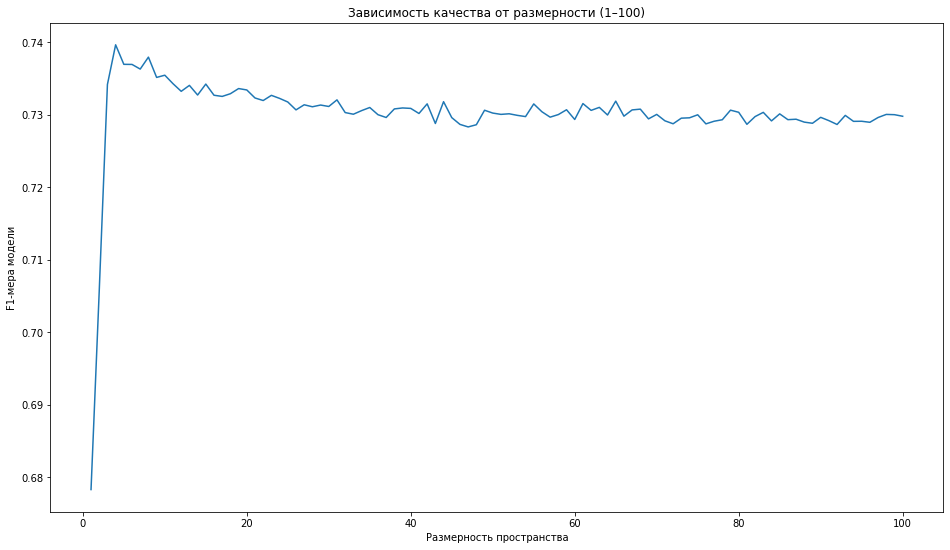

In [43]:
results = []
n_dims = range(1, 101)

for n_dimensions in n_dims:
    pca = PCA(n_components=n_dimensions)
    pca.fit(X)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    forest_pca = RandomForestClassifier(random_state=42)
    forest_pca.fit(X_train_pca, y_train)
    y_pred_pca = forest_pca.predict(X_test_pca)
    results.append(f1_score(y_test, y_pred_pca))
    
f, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x=n_dims, y=results)

plt.xlabel("Размерность пространства")
plt.ylabel("F1-мера модели")
plt.title("Зависимость качества от размерности (1–100)");

Колебания так и продолжаются, но они совсем незначительные — значит, с этими данными и выбранным случайным лесом мы не «пробьём» отметку в 0.74 и можно продолжать эксперименты уже с другими моделями.